In [18]:
import os
import cv2
import numpy as np
import tensorflow_datasets as tfds
import tqdm
import jax
import imageio
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from octo.model.octo_model import OctoModel

In [19]:
# Load Octo model
print("Loading Octo model checkpoint...")
model = OctoModel.load_pretrained("hf://rail-berkeley/octo-base-1.5")

Loading Octo model checkpoint...


In [20]:
# Load multiple episodes from BRIDGE dataset
dataset_split = "train[:100]"  # Adjust number of episodes as needed
builder = tfds.builder_from_directory(builder_dir="gs://gresearch/robotics/bridge/0.1.0/")
ds = builder.as_dataset(split=dataset_split)

In [21]:
def compute_attention_entropy(attn_map):
    # attn_map shape: [num_heads, num_patches]
    entropy = -np.sum(attn_map * np.log(attn_map + 1e-9), axis=-1)  # Avoid log(0)
    return entropy

In [22]:
WINDOW_SIZE = 2
num_episodes = 10

all_pred_actions = []
all_true_actions = []
all_attention_maps = []
all_images = []
all_entropy_maps = []  # Store entropy maps

output_dir = "training_videos_1-10"
os.makedirs(output_dir, exist_ok=True)

def compute_attention_entropy(attn_map):
    # Compute entropy for each head in a single layer
    entropy = -np.sum(attn_map * np.log(attn_map + 1e-9), axis=-1)  # Avoid log(0)
    return entropy

for episode_idx, episode in enumerate(tfds.as_numpy(ds.take(num_episodes))):
    print(f"Processing Episode {episode_idx+1}/{num_episodes}")

    steps = list(episode["steps"])
    images = [cv2.resize(np.array(step["observation"]["image"]), (256, 256)) for step in steps]
    goal_image = images[-1]
    language_instruction = steps[0]["observation"]["natural_language_instruction"].decode()
    all_images.append(images)

    task = model.create_tasks(goals={"image_primary": goal_image[None]})
    pred_actions, true_actions, attention_maps_per_step = [], [], []
    entropy_maps = []  # Store entropy per step

    video_filename = os.path.join(output_dir, f"episode_{episode_idx+1}.mp4")
    video_writer = cv2.VideoWriter(video_filename, cv2.VideoWriter_fourcc(*"mp4v"), 5, (256, 256))

    with open(os.path.join(output_dir, f"episode_{episode_idx+1}_instruction.txt"), "w") as f:
        f.write(language_instruction)

    for step in tqdm.trange(len(images) - (WINDOW_SIZE - 1)):
        input_images = np.stack(images[step:step + WINDOW_SIZE])[None]
        observation = {
            'image_primary': input_images,
            'timestep_pad_mask': np.full((1, input_images.shape[1]), True, dtype=bool)
        }

        actions, attention_maps = model.sample_actions(
            observation,
            task,
            unnormalization_statistics=model.dataset_statistics["bridge_dataset"]["action"],
            rng=jax.random.PRNGKey(0)
        )

        pred_actions.append(actions[0])
        attention_maps_per_step.append(attention_maps)

        # ---- Store true action ----
        final_window_step = step + WINDOW_SIZE - 1
        true_action = np.concatenate(
            (
                steps[final_window_step]['action']['world_vector'],
                steps[final_window_step]['action']['rotation_delta'],
                np.array(steps[final_window_step]['action']['open_gripper']).astype(np.float32)[None]
            ), axis=-1
        )
        true_actions.append(true_action)

        # ---- Write frame to video ----
        frame = images[step]
        video_writer.write(frame)

        # ---- Compute Entropy ----
        num_layers = len(attention_maps["all"])
        num_heads = attention_maps["all"][0][0].shape[0]  # Extract correct num_heads
        entropy_map = np.zeros((num_layers, num_heads))  # Ensure consistent shape

        for layer_idx in range(num_layers):
            attn_map = attention_maps["all"][layer_idx][0]  # Shape: [num_heads, num_patches]
            entropy = compute_attention_entropy(attn_map)  # Shape: [num_heads]
            entropy_map[layer_idx] = entropy  # Store entropy for each head in the layer

        entropy_maps.append(entropy_map)  # Append per-step entropy
    # Convert to NumPy array
    entropy_maps = np.array(entropy_maps)
    print(f"Final entropy_maps shape: {entropy_maps.shape}")  # (num_steps, num_layers, num_heads)

    video_writer.release()
    print(f"Saved training video: {video_filename}")
    print(f"Saved instruction: episode_{episode_idx+1}_instruction.txt")

    # ---- Save results ----
    all_pred_actions.append(pred_actions)
    all_true_actions.append(true_actions)
    all_attention_maps.append(attention_maps_per_step)
    all_entropy_maps.append(entropy_maps)  # Save entropy for the whole episode

print("Processing complete!")

Processing Episode 1/10


100%|██████████| 37/37 [00:20<00:00,  1.83it/s]


Final entropy_maps shape: (37, 12, 12)
Saved training video: training_videos_1-10/episode_1.mp4
Saved instruction: episode_1_instruction.txt
Processing Episode 2/10


100%|██████████| 31/31 [00:13<00:00,  2.37it/s]


Final entropy_maps shape: (31, 12, 12)
Saved training video: training_videos_1-10/episode_2.mp4
Saved instruction: episode_2_instruction.txt
Processing Episode 3/10


100%|██████████| 31/31 [00:12<00:00,  2.40it/s]


Final entropy_maps shape: (31, 12, 12)
Saved training video: training_videos_1-10/episode_3.mp4
Saved instruction: episode_3_instruction.txt
Processing Episode 4/10


100%|██████████| 21/21 [00:08<00:00,  2.42it/s]


Final entropy_maps shape: (21, 12, 12)
Saved training video: training_videos_1-10/episode_4.mp4
Saved instruction: episode_4_instruction.txt
Processing Episode 5/10


100%|██████████| 47/47 [00:19<00:00,  2.41it/s]


Final entropy_maps shape: (47, 12, 12)
Saved training video: training_videos_1-10/episode_5.mp4
Saved instruction: episode_5_instruction.txt
Processing Episode 6/10


100%|██████████| 26/26 [00:10<00:00,  2.40it/s]


Final entropy_maps shape: (26, 12, 12)
Saved training video: training_videos_1-10/episode_6.mp4
Saved instruction: episode_6_instruction.txt
Processing Episode 7/10


100%|██████████| 31/31 [00:12<00:00,  2.44it/s]


Final entropy_maps shape: (31, 12, 12)
Saved training video: training_videos_1-10/episode_7.mp4
Saved instruction: episode_7_instruction.txt
Processing Episode 8/10


100%|██████████| 46/46 [00:19<00:00,  2.41it/s]


Final entropy_maps shape: (46, 12, 12)
Saved training video: training_videos_1-10/episode_8.mp4
Saved instruction: episode_8_instruction.txt
Processing Episode 9/10


100%|██████████| 21/21 [00:08<00:00,  2.39it/s]


Final entropy_maps shape: (21, 12, 12)
Saved training video: training_videos_1-10/episode_9.mp4
Saved instruction: episode_9_instruction.txt
Processing Episode 10/10


100%|██████████| 48/48 [00:20<00:00,  2.39it/s]

Final entropy_maps shape: (48, 12, 12)
Saved training video: training_videos_1-10/episode_10.mp4
Saved instruction: episode_10_instruction.txt
Processing complete!


In [23]:
def overlay_attention_on_image(image, attn_map, patch_size=16):
    num_heads, num_patches = attn_map.shape
    grid_size = int(np.sqrt(num_patches))
    overlayed_images = []

    for head in range(num_heads):
        attn_grid = attn_map[head].reshape((grid_size, grid_size))
        attn_grid = (attn_grid - attn_grid.min()) / (attn_grid.max() - attn_grid.min())
        attn_heatmap = zoom(attn_grid, (patch_size, patch_size), order=1)
        attn_colormap = cv2.applyColorMap((attn_heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
        attn_colormap = cv2.resize(attn_colormap, (image.shape[1], image.shape[0]))
        overlayed_image = cv2.addWeighted(image, 0.6, attn_colormap, 0.4, 0)
        overlayed_images.append(overlayed_image)
    return overlayed_images

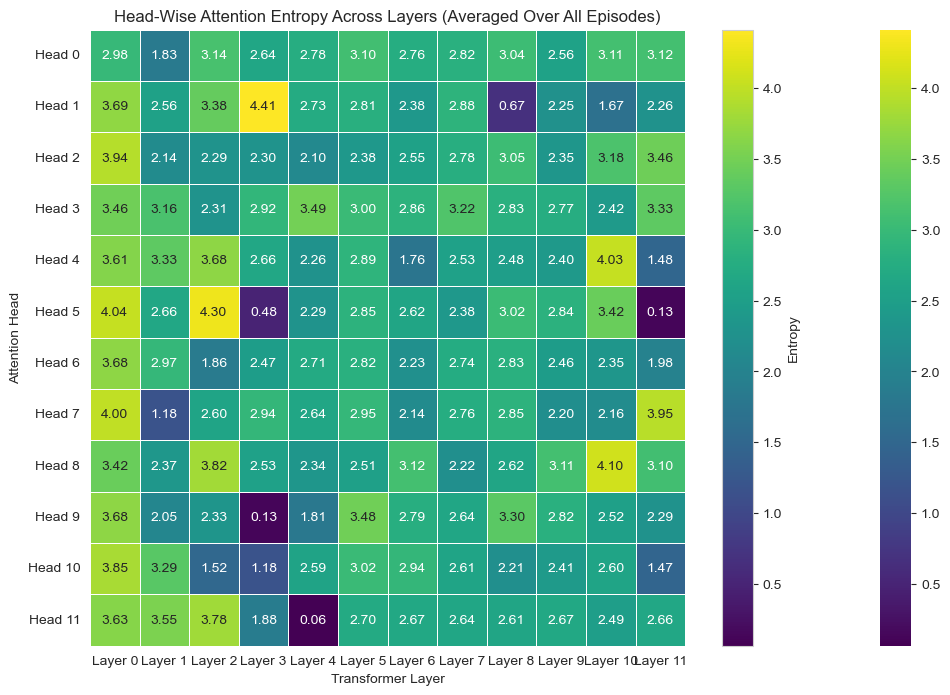

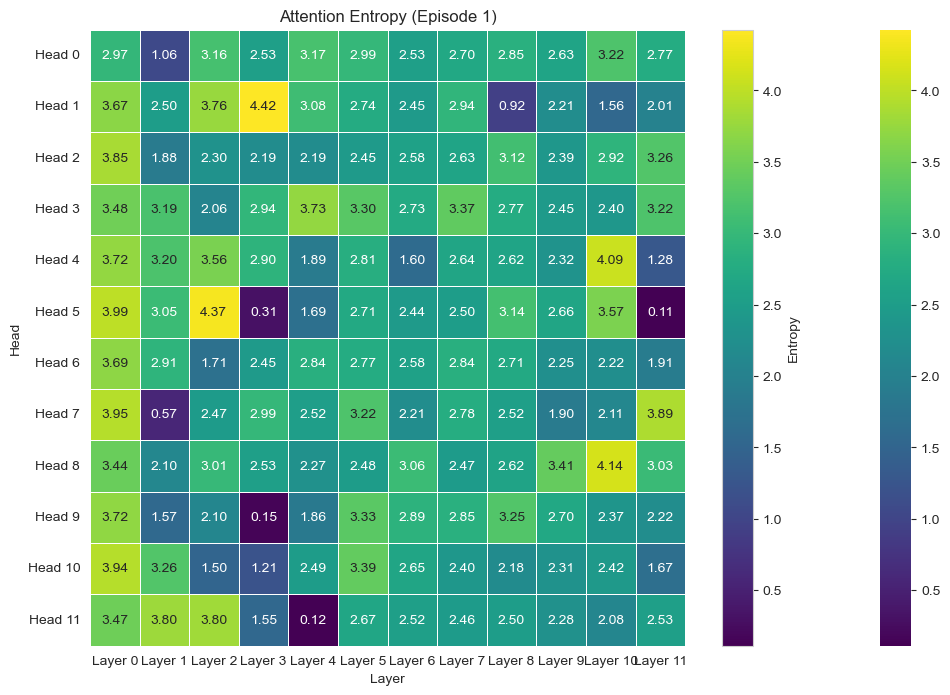

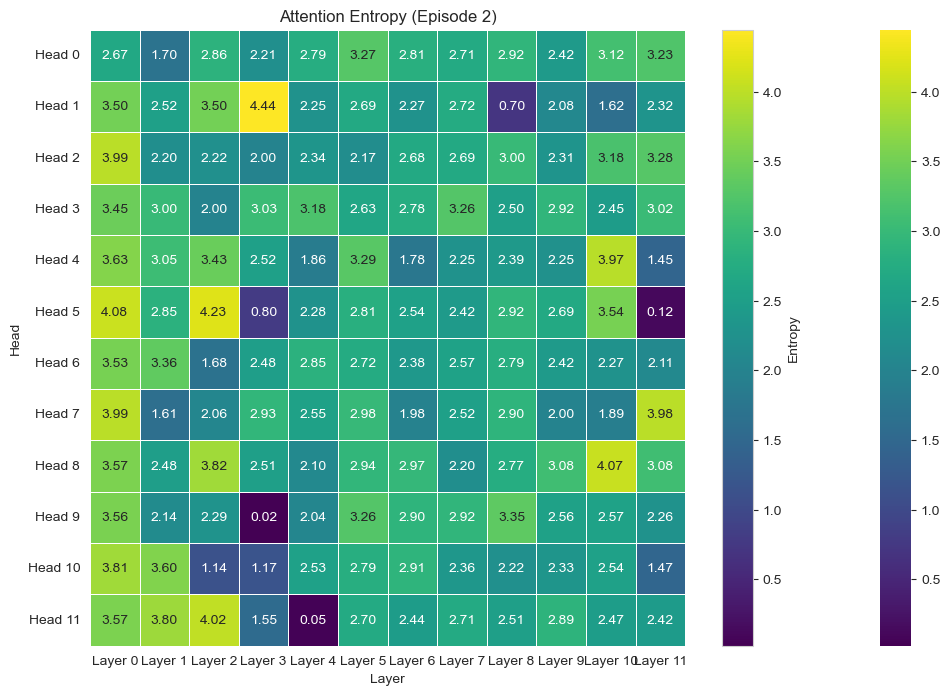

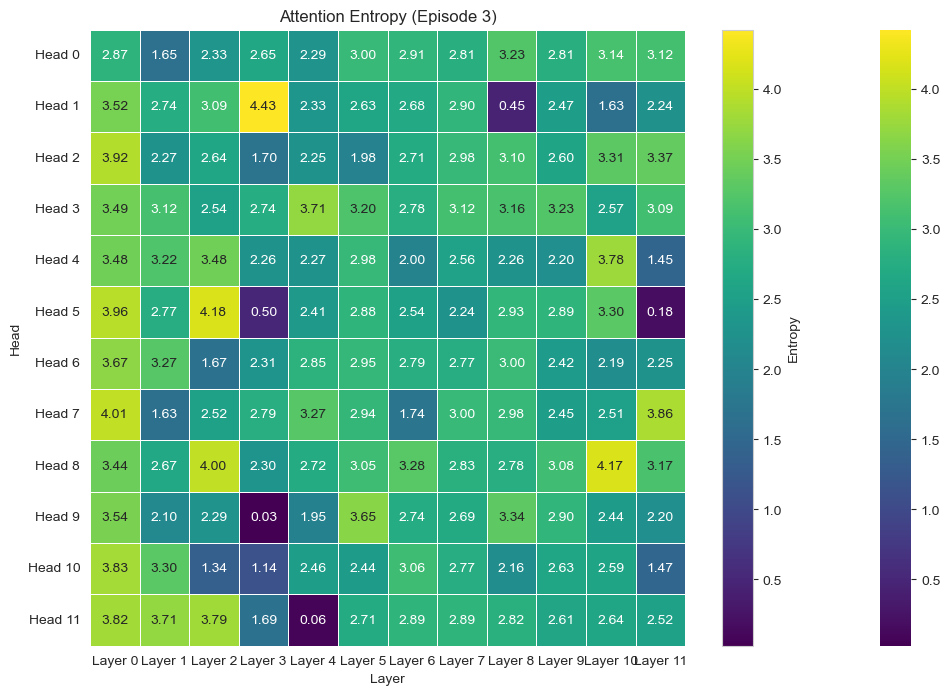

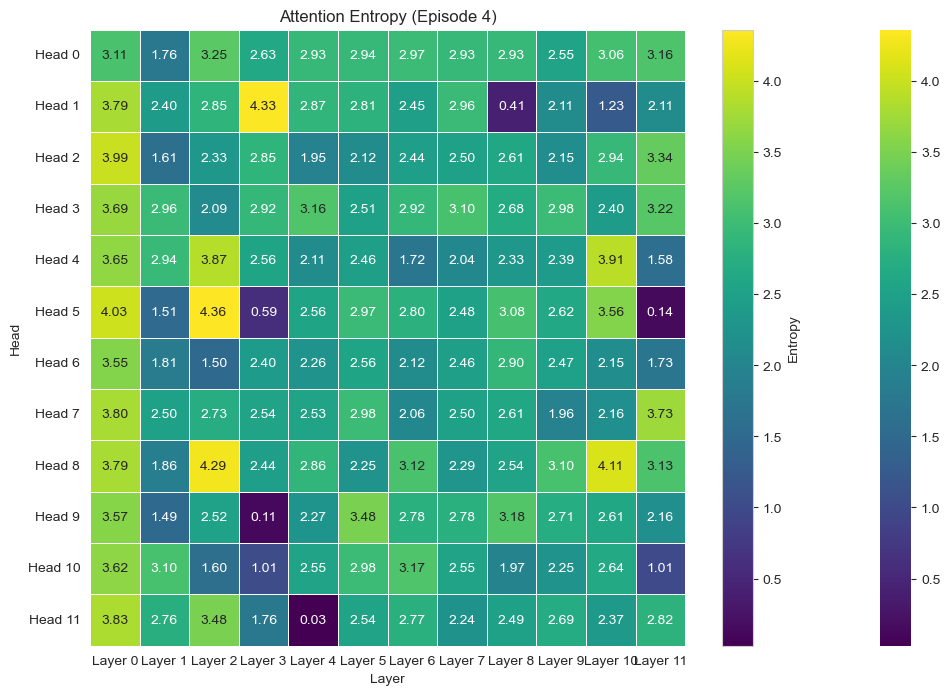

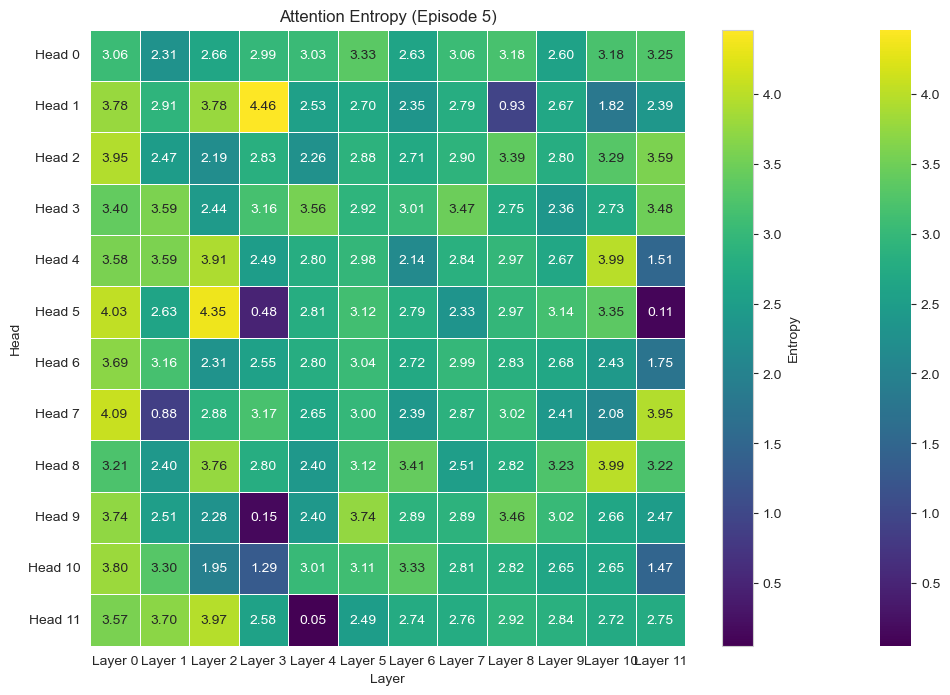

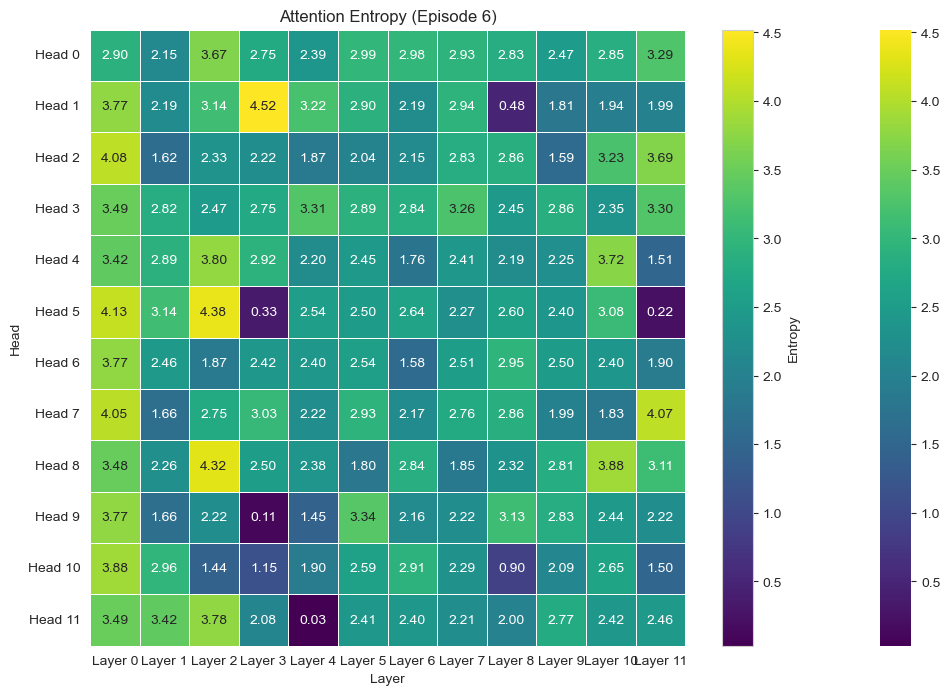

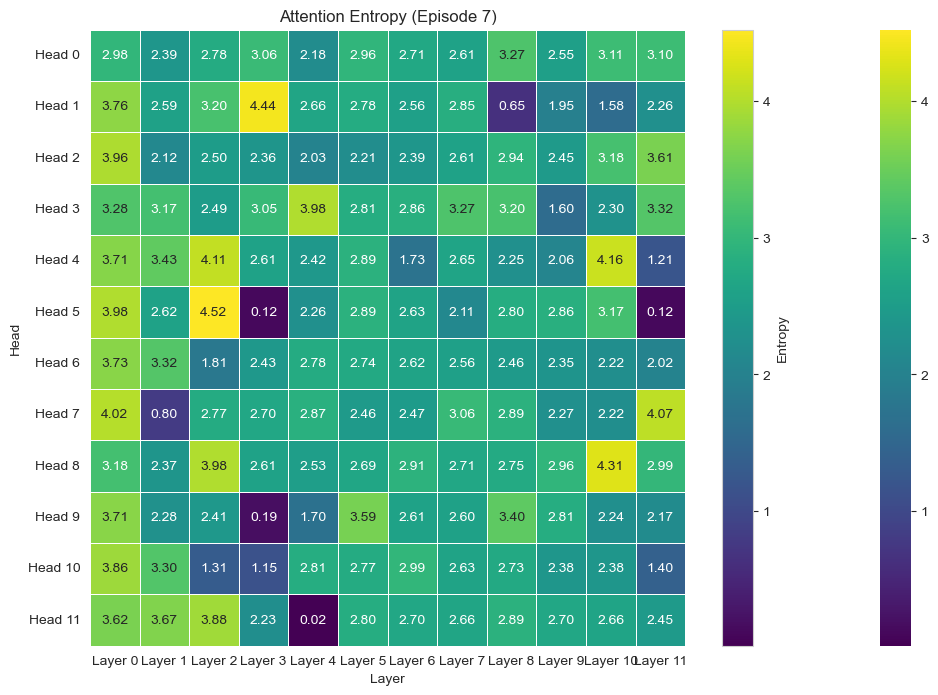

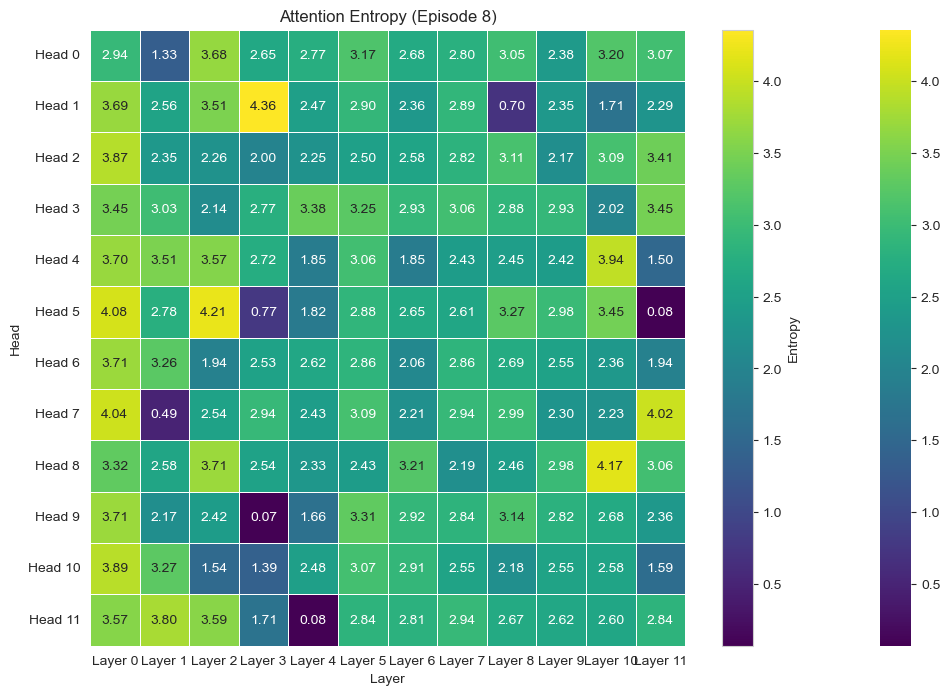

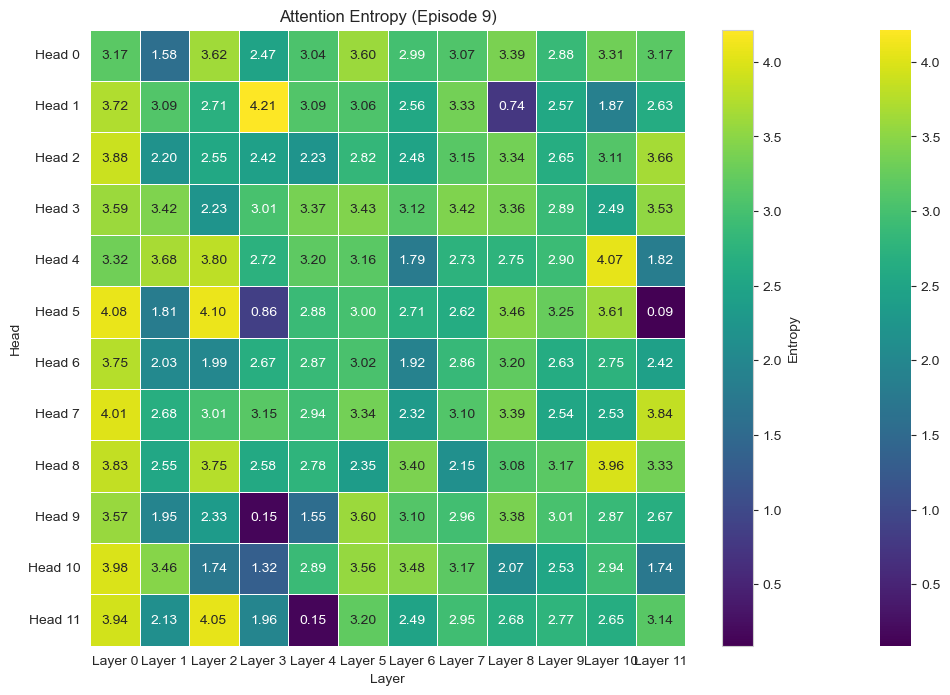

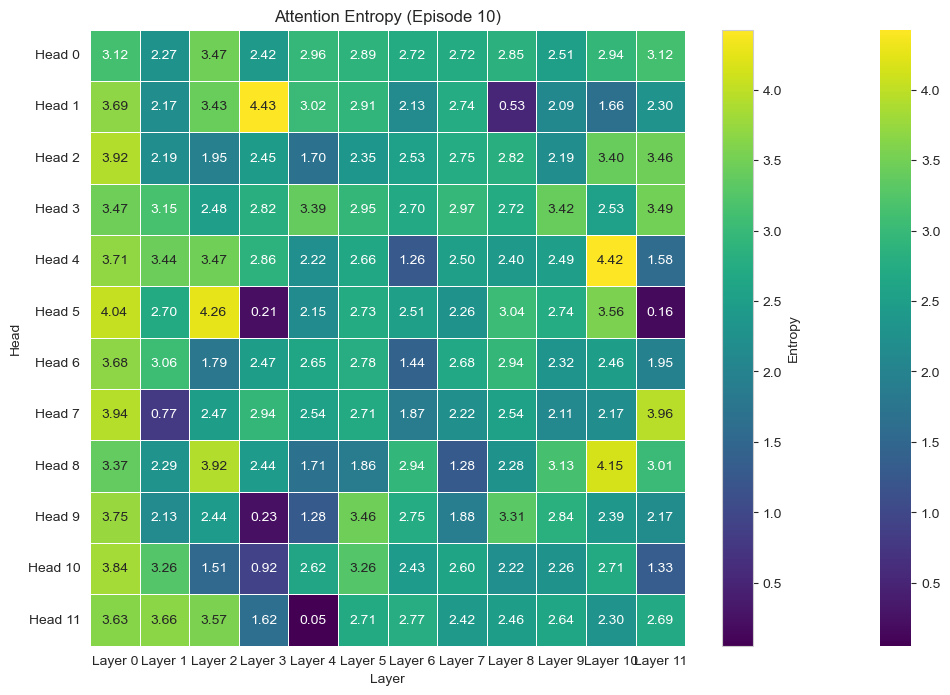

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Find the maximum number of steps in any episode
max_steps = max(entropy_map.shape[0] for entropy_map in all_entropy_maps)

# Pad all episodes to the max step length
padded_entropy_maps = [
    np.pad(entropy_map, ((0, max_steps - entropy_map.shape[0]), (0, 0), (0, 0)), constant_values=np.nan)
    for entropy_map in all_entropy_maps
]

# Convert to numpy array (now uniform shape)
padded_entropy_maps = np.array(padded_entropy_maps)

# Compute mean across valid (non-NaN) values
avg_entropy_maps = np.nanmean(padded_entropy_maps, axis=(0, 1))  # Mean over episodes & steps

# Plot the heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    avg_entropy_maps.T,
    cmap="viridis",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    xticklabels=[f"Layer {i}" for i in range(avg_entropy_maps.shape[0])],
    yticklabels=[f"Head {i}" for i in range(avg_entropy_maps.shape[1])]
)

plt.title("Head-Wise Attention Entropy Across Layers (Averaged Over All Episodes)")
plt.xlabel("Transformer Layer")
plt.ylabel("Attention Head")
plt.colorbar(ax.collections[0], label="Entropy")
plt.show()


# Iterate over all episodes and generate a heatmap for each
for episode_idx, entropy_map in enumerate(all_entropy_maps):
    avg_entropy_per_episode = entropy_map.mean(axis=0)  # Average over steps within each episode

    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(
        avg_entropy_per_episode.T,
        cmap="viridis",
        annot=True,  # Show entropy values
        fmt=".2f",
        linewidths=0.5,
        xticklabels=[f"Layer {i}" for i in range(avg_entropy_per_episode.shape[0])],
        yticklabels=[f"Head {i}" for i in range(avg_entropy_per_episode.shape[1])]
    )

    plt.title(f"Attention Entropy (Episode {episode_idx + 1})")
    plt.xlabel("Layer")
    plt.ylabel("Head")
    plt.colorbar(ax.collections[0], label="Entropy")
    plt.show()

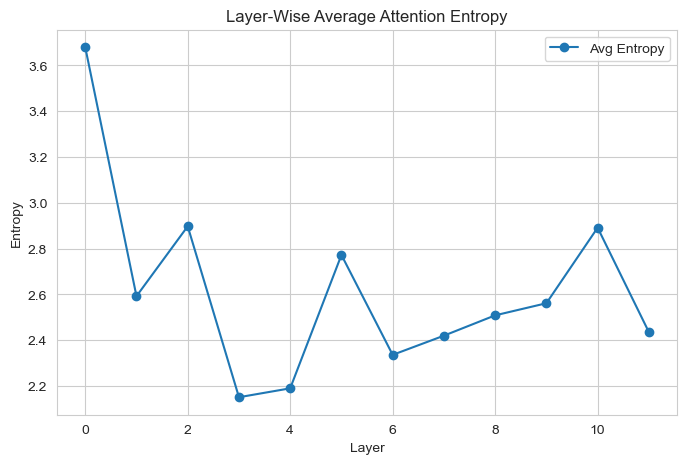

In [25]:
entropy_maps = np.array(entropy_maps)  # Ensure it is a numpy array

# Ensure entropy_maps has shape (num_steps, num_layers, num_heads)
assert len(entropy_maps.shape) == 3, f"Unexpected shape: {entropy_maps.shape}"

# Compute layer-wise average entropy (mean over steps and heads)
avg_entropy_per_layer = entropy_maps.mean(axis=(0, 2))  # Shape: [num_layers]

# Plot layer-wise entropy
plt.figure(figsize=(8, 5))
plt.plot(range(len(avg_entropy_per_layer)), avg_entropy_per_layer, marker="o", linestyle="-", label="Avg Entropy")
# plt.axvline(x=8, color="red", linestyle="--", label="High focus layers")
# plt.axvline(x=10, color="orange", linestyle="--", label="Semantic drift starts")
plt.title("Layer-Wise Average Attention Entropy")
plt.xlabel("Layer")
plt.ylabel("Entropy")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
def generate_videos_for_heads(save_path="attention_results1-5", head_idx=0):
    for episode_folder in sorted(os.listdir(save_path)):
        episode_path = os.path.join(save_path, episode_folder)

        if not os.path.isdir(episode_path):
            continue

        head_video_path = os.path.join(episode_path, f"head_{head_idx}.mp4")
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        video_writer = None

        for layer_folder in sorted(os.listdir(episode_path)):
            layer_path = os.path.join(episode_path, layer_folder)

            if not os.path.isdir(layer_path):
                continue

            images = sorted(
                [img for img in os.listdir(layer_path) if img.endswith(".png")],
                key=lambda x: int(x.split('_')[1].split('.')[0])
            )

            for img in images:
                img_path = os.path.join(layer_path, img)
                frame = cv2.imread(img_path)

                if video_writer is None:
                    height, width, _ = frame.shape
                    video_writer = cv2.VideoWriter(head_video_path, fourcc, 5, (width, height))

                video_writer.write(frame)

        if video_writer:
            video_writer.release()
            print(f"Saved head attention video: {head_video_path}")

Interpolation (Smoothing):

zoom(attn_grid, (patch_size, patch_size), order=1) upscales the coarse attention map using bilinear interpolation (order=1), which makes the attention map appear smoother rather than blocky.


Visualizing Episode 1:  51%|█████▏    | 19/37 [01:53<01:47,  5.95s/it]


KeyboardInterrupt: 

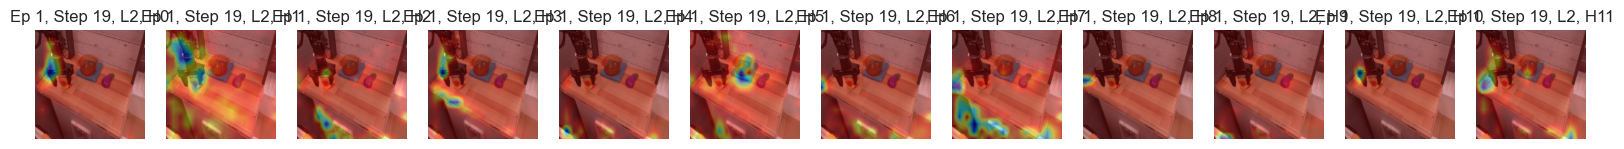

In [27]:
def visualize_attention_episodes(all_attention_maps, all_images, save_path="attention_results1-5", last_n_layers=12):
    os.makedirs(save_path, exist_ok=True)

    for episode_idx, attention_maps_per_step in enumerate(all_attention_maps):
        episode_save_path = os.path.join(save_path, f"episode_{episode_idx+1}")
        os.makedirs(episode_save_path, exist_ok=True)  # Create a directory for each episode

        images = all_images[episode_idx]
        num_steps = len(attention_maps_per_step)
        num_layers = len(attention_maps_per_step[0]["all"])

        for step in tqdm.trange(num_steps, desc=f"Visualizing Episode {episode_idx+1}"):
            image = images[step]

            for layer_idx in range(num_layers - last_n_layers, num_layers):
                layer_save_path = os.path.join(episode_save_path, f"layer_{layer_idx}")
                os.makedirs(layer_save_path, exist_ok=True)  # Create sub-folder for each layer in the episode

                attn_map = attention_maps_per_step[step]["all"][layer_idx][0]
                if attn_map.ndim != 2:
                    continue

                overlayed_images = overlay_attention_on_image(image, attn_map)
                num_heads = attn_map.shape[0]
                fig, axes = plt.subplots(1, num_heads, figsize=(20, 5))

                for head_idx in range(num_heads):
                    axes[head_idx].imshow(overlayed_images[head_idx])
                    axes[head_idx].set_title(f"Ep {episode_idx+1}, Step {step}, L{layer_idx}, H{head_idx}")
                    axes[head_idx].axis("off")

                plt.tight_layout()
                plt.savefig(os.path.join(layer_save_path, f"step_{step}.png"))
                plt.close()

visualize_attention_episodes(all_attention_maps, all_images)

In [ ]:
import cv2
import os
import tqdm

def create_video_from_images(image_folder, video_path, fps=2):
    """
    Creates a video from images stored in a folder.

    Args:
        image_folder (str): Path to the folder containing images.
        video_path (str): Path to save the output video file.
        fps (int): Frames per second.
    """
    images = sorted([img for img in os.listdir(image_folder) if img.endswith(".png")], key=lambda x: int(x.split('_')[1].split('.')[0]))

    if not images:
        print(f"No images found in {image_folder}, skipping video creation.")
        return

    first_image = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, _ = first_image.shape

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4
    video = cv2.VideoWriter(video_path, fourcc, fps, (width, height))

    for image in images:
        img_path = os.path.join(image_folder, image)
        frame = cv2.imread(img_path)
        video.write(frame)

    video.release()
    print(f"Video saved: {video_path}")

def generate_videos_for_layers(save_path="attention_results1-5"):
    """
    Generates videos for each layer across all episodes.

    Args:
        save_path (str): The root folder containing episode directories.
    """
    for episode_folder in sorted(os.listdir(save_path)):
        episode_path = os.path.join(save_path, episode_folder)

        if not os.path.isdir(episode_path):
            continue

        print(f"Generating videos for {episode_folder}...")

        for layer_folder in sorted(os.listdir(episode_path)):
            layer_path = os.path.join(episode_path, layer_folder)

            if not os.path.isdir(layer_path):
                continue

            video_path = os.path.join(episode_path, f"{layer_folder}new.mp4")
            create_video_from_images(layer_path, video_path)

generate_videos_for_layers()

In [ ]:
def create_video_from_images(image_folder, video_path, fps=2):
    images = sorted([img for img in os.listdir(image_folder) if img.endswith(".png")], key=lambda x: int(x.split('_')[1].split('.')[0]))

    if not images:
        print(f"No images found in {image_folder}, skipping video creation.")
        return

    first_image = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, _ = first_image.shape

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4
    video = cv2.VideoWriter(video_path, fourcc, fps, (width, height))

    for image in images:
        img_path = os.path.join(image_folder, image)
        frame = cv2.imread(img_path)
        video.write(frame)

    video.release()
    print(f"Video saved: {video_path}")

def visualize_attention_across_layers(all_attention_maps, all_images, save_path="attention_results_heads", last_n_layers=12):
    os.makedirs(save_path, exist_ok=True)

    for episode_idx, attention_maps_per_step in enumerate(all_attention_maps):
        episode_save_path = os.path.join(save_path, f"episode_{episode_idx+1}")
        os.makedirs(episode_save_path, exist_ok=True)

        images = all_images[episode_idx]
        num_steps = len(attention_maps_per_step)
        num_layers = len(attention_maps_per_step[0]["all"])

        for step in tqdm.trange(num_steps, desc=f"Visualizing Episode {episode_idx+1}"):
            image = images[step]

            for head_idx in range(attention_maps_per_step[step]["all"][0][0].shape[0]):  # Loop over heads
                head_save_path = os.path.join(episode_save_path, f"head_{head_idx}")
                os.makedirs(head_save_path, exist_ok=True)

                frames = []  # To store the frame sequence

                for layer_idx in range(num_layers - last_n_layers, num_layers):
                    attn_map = attention_maps_per_step[step]["all"][layer_idx][0]

                    if attn_map.ndim != 2:
                        continue

                    overlayed_image = overlay_attention_on_image(image, attn_map[head_idx])
                    frame_path = os.path.join(head_save_path, f"step_{step}_layer_{layer_idx}.png")

                    # Save individual frames
                    plt.imshow(overlayed_image)
                    plt.title(f"Ep {episode_idx+1}, Step {step}, L{layer_idx}, H{head_idx}")
                    plt.axis("off")
                    plt.savefig(frame_path)
                    plt.close()

                    frames.append(frame_path)

                # Create video for each head across layers at a specific step
                if frames:
                    video_path = os.path.join(head_save_path, f"step_{step}_head_{head_idx}_layers.mp4")
                    create_video_from_images(head_save_path, video_path)

def generate_videos_for_heads(save_path="attention_results_heads"):
    for episode_folder in sorted(os.listdir(save_path)):
        episode_path = os.path.join(save_path, episode_folder)

        if not os.path.isdir(episode_path):
            continue

        print(f"Generating head-based videos for {episode_folder}...")

        for head_folder in sorted(os.listdir(episode_path)):
            head_path = os.path.join(episode_path, head_folder)

            if not os.path.isdir(head_path):
                continue

            video_path = os.path.join(episode_path, f"{head_folder}_layers.mp4")
            create_video_from_images(head_path, video_path)

# Example usage
visualize_attention_across_layers(all_attention_maps, all_images)
generate_videos_for_heads()

In [ ]:
def evaluate_action_accuracy(pred_actions, true_actions):
    """
    Evaluates the quality of predicted actions using L2 distance and cosine similarity.

    Args:
        pred_actions (list of np.array): List of predicted actions.
        true_actions (list of np.array): List of ground truth actions.

    Returns:
        dict: Dictionary containing L2 distance and cosine similarity per episode.
    """
    results = {}

    for episode_idx, (pred, true) in enumerate(zip(pred_actions, true_actions)):
        pred = np.array(pred)  # Shape: (num_steps, action_horizon, action_dim)
        true = np.array(true)  # Shape: (num_steps, action_dim)

        if pred.ndim == 3:  # If prediction has action horizon, reduce dimension
            pred = pred[:, 0, :]  # Option 1: Take the first action per step
            # pred = pred.mean(axis=1)  # Option 2: Average over horizon

        if pred.shape != true.shape:
            print(f"Warning: Shape mismatch in Episode {episode_idx+1}. Pred: {pred.shape}, True: {true.shape}")
            continue  # Skip problematic episodes

        l2_dist = np.linalg.norm(pred - true, axis=1)  # L2 distance per step
        cos_sim = np.sum(pred * true, axis=1) / (np.linalg.norm(pred, axis=1) * np.linalg.norm(true, axis=1))  # Cosine similarity

        results[f"episode_{episode_idx+1}"] = {
            "l2_mean": np.mean(l2_dist),
            "l2_std": np.std(l2_dist),
            "cosine_mean": np.mean(cos_sim),
            "cosine_std": np.std(cos_sim),
        }

    return results

# Example usage
results = evaluate_action_accuracy(all_pred_actions, all_true_actions)
for ep, metrics in results.items():
    print(f"{ep}: L2 Distance: {metrics['l2_mean']:.3f}, Cosine Similarity: {metrics['cosine_mean']:.3f}")

SUCCESS_THRESHOLD_L2 = 0.1  # Set threshold based on data
SUCCESS_THRESHOLD_COS = 0.9

def evaluate_success(results):
    success_rates = []
    for ep, metrics in results.items():
        l2_score = metrics["l2_mean"]
        cos_score = metrics["cosine_mean"]

        # Weighted decision: if one is good, still count as success
        success = (l2_score < SUCCESS_THRESHOLD_L2) or (cos_score > SUCCESS_THRESHOLD_COS)
        success_rates.append(success)

        print(f"{ep}: {'Success' if success else 'Failure'}")

    overall_success = np.mean(success_rates) * 100
    print(f"Overall success rate: {overall_success:.2f}%")

evaluate_success(results)